In [1]:
import tensorflow as tf
import numpy as np
import time
from preprocess import get_window
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.utils import to_categorical
from tqdm import tqdm
import os
import logging

Using TensorFlow backend.


In [2]:
'''
한개의 time 단위로 train => time 기준 batch_size=1
한개의 time에 8개의 node가 있으므로 전체적으로 보면 node 8개씩 trian하는 꼴
masking 사용하지 않음 => F1 score나 confusion matrix로 보여줄 것이기 때문
rnn: (batch_size, timesteps, num_input)
'''
class GCN_WITH_LSTM():
    def __init__(self, frame_size, nomalized_adj, input_dim=8, num_nodes=8, num_classes=4):

        init = tf.initializers.he_normal()
        lstm_hidden = 64
        num_lstm_layers = 1
        gcn_hidden = 64
        
        # placeholders
        self.x = tf.placeholder(tf.float32, [num_nodes, frame_size, input_dim])
        self.y = tf.placeholder(tf.float32, [num_nodes, num_classes])
        
        # normalized adj matrix for GCN
        # you can improve this by using sparse tensor when adj matrix is large
        self.A = tf.constant(nomalized_adj, dtype=tf.float32)

        # define lstm cell
        cell = tf.nn.rnn_cell.LSTMCell(lstm_hidden)
        cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_lstm_layers)
                
        # forward lstm, use tf.unstack for statc_rnn
        # outputs[-1] represents last hidden state of each batch, shape: (batch_size, lstm_hidden)
        outputs, _ = tf.nn.static_rnn(cell, tf.unstack(self.x, axis=1), dtype=tf.float32)
        
        # forward GCN
        self.w1 = tf.Variable(init([lstm_hidden, gcn_hidden]))
        self.h1 = tf.matmul(tf.matmul(self.A, outputs[-1]), self.w1)
        
        self.w2 = tf.Variable(init([gcn_hidden, num_classes]))
        self.h2 = tf.matmul(tf.matmul(self.A, self.h1), self.w2)
        
        # prediction
        self.pred = tf.argmax(self.h2, axis=1)
        
        # loss function
        # (as far as I know) we cannot directly optimize metric(F1 score, accuracy ...etc)
        self.loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.h2, labels=self.y))

        # optimizer
        optimizer = tf.train.AdamOptimizer()
        self.train_step = optimizer.minimize(self.loss)

In [3]:
def get_adj_matrix():
    return np.array([
        [0, 1, 0, 0, 0, 0, 0, 1],
        [1, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 1],
        [1, 0, 0, 0, 0, 0, 1, 0],
    ])
    
# make DAD(normalization) matrix
def normalize_matrix(adj_matrix):
    a_tilda = adj_matrix + np.eye(adj_matrix.shape[0]) # A_ = A+I
    d_tilda = np.diag(1 / np.sqrt(np.sum(a_tilda, axis=1))) # D_^(-1/2)
    return np.matmul(np.matmul(d_tilda, a_tilda), d_tilda)

In [4]:
def get_accuracy(true, pred):
    '''
    true: numpy array of shape (num_examples, num_nodes, num_classes)
    pred: numpy array of shape (total_examples)
    '''
    
    true = np.argmax(true, axis=2)
    true = np.reshape(true, -1)
    return np.mean(np.equal(true, pred).astype(np.float32))

def get_f1_score(true, pred):
    '''
    true: numpy array of shape (num_examples, num_nodes, num_classes)
    pred: numpy array of shape (total_examples)
    
    use 'weighted' parameter for sklearn.metrics.f1_score
    https://datascience.stackexchange.com/questions/40900/whats-the-difference-between-sklearn-f1-score-micro-and-weighted-for-a-mult
    '''
    
    true = np.argmax(true, axis=2)
    true = np.reshape(true, -1)
    return f1_score(true, pred, average='weighted')  

In [5]:
# def train_model():
#     epochs = 5
#     normalized_adj = normalize_matrix(get_adj_matrix())
#     frame_size = 40 # 5sec
#     after = 80 # 10sec
    
#     # model
#     model = GCN_WITH_LSTM(frame_size, normalized_adj)
#     pred = model.pred
#     loss = model.loss
#     train_step = model.train_step
    
#     # load data
#     x, y = get_window('./data/1234people_160000frame_simple', frame_size, after)
#     y = to_categorical(y) # onehot encoding
#     x = x[:5000, :, :, :]
#     y = y[:5000, :, :]
    
#     # x.shape: (num_examples, num_nodes, frame_size, 8)
#     # y.shape: (num_examples, num_nodes, num_classes)
#     print('train_model shape:', x.shape, y.shape)
    
#     # train, valid, test split
#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
#     x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
    
#     print('train:', x_train.shape, y_train.shape)
#     print('valid:', x_valid.shape, y_valid.shape)
#     print('test:', x_test.shape, y_test.shape)
    
    
#     # do not use cpu because of GPU memory error
#     with tf.Session(config=tf.ConfigProto(device_count={'GPU': 0})) as sess:
#         sess.run(tf.global_variables_initializer())
        
#         for epoch in range(epochs):

#             num_iter_train = x_train.shape[0]
#             num_iter_valid = x_valid.shape[0]
#             loss_train = 0.0
#             loss_valid = 0.0
#             pred_train = [] # use python list for append performace
#             pred_valid = [] # use python list for append performace
#             # metric: accuracy, f1 score, 
#             # early stopping 기준: valid loss
            
#             # train set
#             for i in tqdm(range(num_iter_train), desc='Train set'):
#                 curr_x = x_train[i, :, :, :]
#                 curr_y = y_train[i, :, :]
#                 _loss, _pred, _ = sess.run([loss, pred, train_step], feed_dict={
#                     model.x: curr_x,
#                     model.y: curr_y,
#                 })
                
#                 pred_train.extend(_pred.tolist())
#                 loss_train += _loss
                
#             # valid set
#             for i in tqdm(range(num_iter_valid), desc='Valid set'):
#                 curr_x = x_valid[i, :, :, :]
#                 curr_y = y_valid[i, :, :]
#                 _loss, _pred = sess.run([loss, pred], feed_dict={
#                     model.x: curr_x,
#                     model.y: curr_y,
#                 })
                
#                 pred_valid.extend(_pred.tolist())
#                 loss_valid += _loss
                
#             loss_train = loss_train / num_iter_train
#             acc_train = get_accuracy(y_train, np.array(pred_train))
#             f1_train = get_f1_score(y_train, np.array(pred_train))
#             loss_valid = loss_valid / num_iter_valid
#             acc_valid = get_accuracy(y_valid, np.array(pred_valid))
#             f1_valid = get_f1_score(y_valid, np.array(pred_valid))

#             print('epoch: %3d, tr loss: %.3f, tr acc: %.3f, tr f1: %.3f, vd loss %.3f, vd acc: %.3f, vd f1: %.3f' %
#                  (epoch, loss_train, acc_train, f1_train, loss_valid, acc_valid, f1_valid))
        
# train_model()

In [ ]:
# set logger
logger = logging.getLogger('gcn_with_lstm')
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(os.path.join('.', 'gcn_with_lstm.log'))
logger.addHandler(file_handler)

In [6]:
epochs = 100
normalized_adj = normalize_matrix(get_adj_matrix())
frame_size = 40 # 5sec
after = 80 # 10sec

# model
model = GCN_WITH_LSTM(frame_size, normalized_adj)
pred = model.pred
loss = model.loss
train_step = model.train_step

# load data
x, y = get_window('./data/1234people_160000frame_simple', frame_size, after)
y = to_categorical(y) # onehot encoding

# x.shape: (num_examples, num_nodes, frame_size, 8)
# y.shape: (num_examples, num_nodes, num_classes)
print('train_model shape:', x.shape, y.shape)

# train, valid, test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print('train:', x_train.shape, y_train.shape)
print('valid:', x_valid.shape, y_valid.shape)
print('test:', x_test.shape, y_test.shape)

Nodes:   0%|          | 0/8 [00:00<?, ?it/s]

start "get_window(./data/1234people_160000frame_simple, 40, 80, 8)"...
start "load_data(./data/1234people_160000frame_simple, 8)"...


Total frame:   0%|          | 0/159881 [00:00<?, ?it/s]

end "load_data(./data/1234people_160000frame_simple, 8)"!


Total frame: 100%|██████████| 159881/159881 [01:15<00:00, 2106.06it/s]


end "get_window(./data/1234people_160000frame_simple, 40, 80, 8)"!
train_model shape: (159881, 8, 40, 8) (159881, 8, 4)
train: (102323, 8, 40, 8) (102323, 8, 4)
valid: (25581, 8, 40, 8) (25581, 8, 4)
test: (31977, 8, 40, 8) (31977, 8, 4)


In [ ]:
# do not use cpu because of GPU memory error
sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

In [ ]:
for epoch in range(epochs):
    t1 = time.time()
    num_iter_train = x_train.shape[0]
    num_iter_valid = x_valid.shape[0]
    loss_train = 0.0
    loss_valid = 0.0
    pred_train = [] # use python list for append performace
    pred_valid = [] # use python list for append performace
    # metric: accuracy, f1 score, 
    # early stopping 기준: valid loss

    # train set
#     for i in range(num_iter_train):
    for i in tqdm(range(num_iter_train), desc='Train set'):
        curr_x = x_train[i, :, :, :]
        curr_y = y_train[i, :, :]
        _loss, _pred, _ = sess.run([loss, pred, train_step], feed_dict={
            model.x: curr_x,
            model.y: curr_y,
        })

        pred_train.extend(_pred.tolist())
        loss_train += _loss

    # valid set
#     for i in range(num_iter_valid):
    for i in tqdm(range(num_iter_valid), desc='Valid set'):
        curr_x = x_valid[i, :, :, :]
        curr_y = y_valid[i, :, :]
        _loss, _pred = sess.run([loss, pred], feed_dict={
            model.x: curr_x,
            model.y: curr_y,
        })

        pred_valid.extend(_pred.tolist())
        loss_valid += _loss

    loss_train = loss_train / num_iter_train
    acc_train = get_accuracy(y_train, np.array(pred_train))
    f1_train = get_f1_score(y_train, np.array(pred_train))
    loss_valid = loss_valid / num_iter_valid
    acc_valid = get_accuracy(y_valid, np.array(pred_valid))
    f1_valid = get_f1_score(y_valid, np.array(pred_valid))

    t2 = time.time()
    
    saver.save(sess, "checkpoint/train", epoch)
    logger.info('epoch: %3d, elapsed: %3d, tr loss: %.3f, tr acc: %.3f, tr f1: %.3f, vd loss %.3f, vd acc: %.3f, vd f1: %.3f' %
         (epoch, t2-t1, loss_train, acc_train, f1_train, loss_valid, acc_valid, f1_valid))
    print('epoch: %3d, elapsed: %3d, tr loss: %.3f, tr acc: %.3f, tr f1: %.3f, vd loss %.3f, vd acc: %.3f, vd f1: %.3f' %
         (epoch, t2-t1, loss_train, acc_train, f1_train, loss_valid, acc_valid, f1_valid))

In [16]:
# test set performance
from preprocess import pick_index
index = pick_index(y_test)

In [32]:
sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())
ckpt_path = saver.restore(sess, "checkpoint/train-27")

INFO:tensorflow:Restoring parameters from checkpoint/train-27


In [50]:
loss_test = 0.0
pred_test = []
true_test = []
num_iter_test = index.shape[0]
# 전체 y_test가 아니라 index를 이용한 특정 구간에서만 test
for i in tqdm(range(num_iter_test)):
    t, n = index[i]
    curr_x = x_test[t, :, :, :]
    curr_y = y_test[t, :, :]
    _loss, _pred = sess.run([loss, pred], feed_dict={
        model.x: curr_x,
        model.y: curr_y,
    })

    pred_test.append(_pred[n])
    true_test.append(y_test[t, n])
    loss_test += _loss


100%|██████████| 1563/1563 [00:05<00:00, 289.34it/s]


In [51]:
true_test = np.argmax(np.array(true_test), axis=1)
pred_test = np.array(pred_test)

In [57]:
np.equal(true_test, pred_test)

array([ True,  True,  True, ..., False, False, False])

In [58]:
print('loss: %.3f, acc: %.3f, f1: %.3f' % (loss_test/num_iter_test, test_acc, test_f1))

loss: 0.531, acc: 0.324, f1: 0.164


In [59]:
import seaborn as sns
import matplotlib.pyplot as plt     
from sklearn.metrics import confusion_matrix

In [60]:
cm = confusion_matrix(true_test, pred_test)

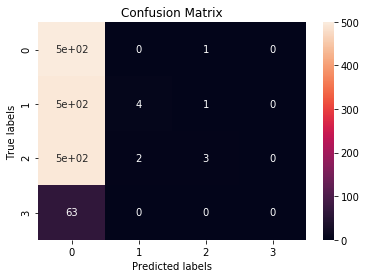

In [61]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 